<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import ast

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)

In [3]:
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {loc:[models[loc].cross_entropy(proverb.lower())] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Αχτυπούν του παπά με τα πρόσφορα, τζαι λαλεί, Θεέ μου, τζαι 'ξόρισ' την ορκήσ σου (Κύπρος) -- predicted as: Cyprus


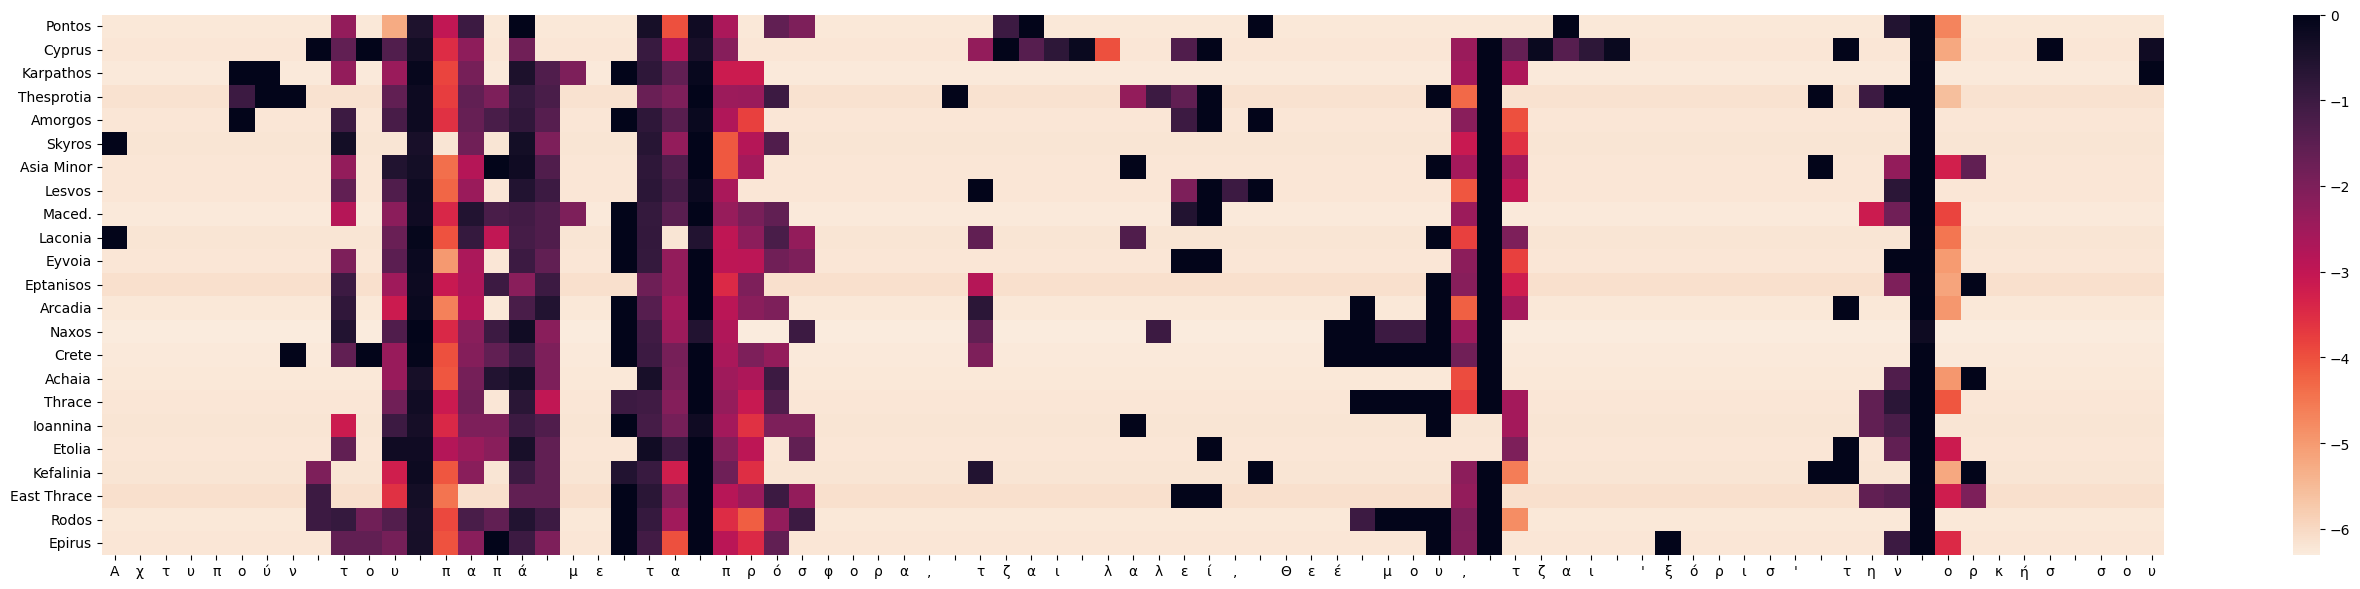

In [9]:
t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout(); ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

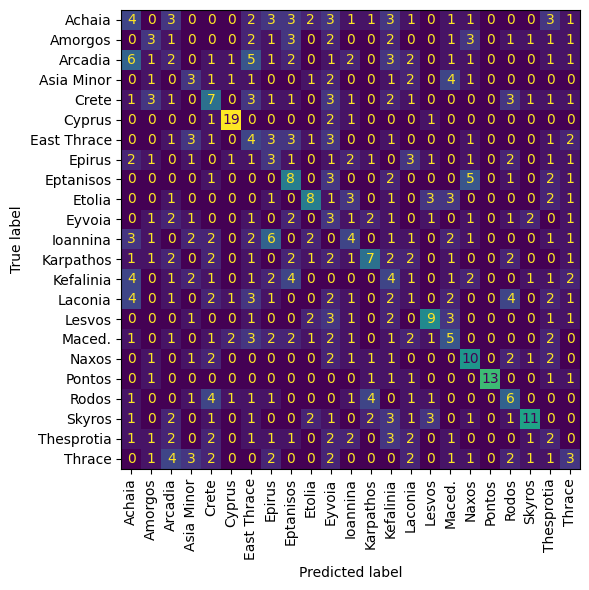

In [11]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(gold, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

* Benchmarking standard text classifiers, on top of chanracter n-grams

In [12]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


In [13]:
# benchmarking text classification algorithms
def benchmark_clf(train, dev):
    for algo_name, algorithm in (('SVM', LinearSVC), 
                                 ('KNN', KNeighborsClassifier),
                                 ('Forest', RandomForestClassifier), 
                                 ('LR', LogisticRegression)):
        vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=2, lowercase=True)
        locator = Pipeline([('vect', vect), ('clf', algorithm())]) 
        locator.fit(train.text.values, train.area.values) 
        preds = locator.predict(test.text.values) 
        print(f'{algo_name}\n{classification_report(test.area.values, preds)}')

benchmark_clf(train, dev)

SVM
                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10

In [14]:
# inference on test data:
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

## Predicting the location of proverbs
* Focusing on ones which are shared in multiple locations

In [15]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
1,"Άβολος ο νους, διπλός ο κόπος","{Μικρά Ασία>Τσεσμές (Κρήνη), Νίσυρος}",2,"{Μικρά Ασία, Νίσυρος}",2,"[(36.58904575, 27.16918402255752), (38.1846366..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θράκη, Θήρα (Σαντορίνη)}",2,"[(40.8464241, 25.8759377), (36.4044251, 25.395..."
3,"Άβουλος νους, διπλός ο κόπος","{Ρόδος, Αμοργός, Κρήτη}",3,"{Ρόδος, Αμοργός, Κρήτη}",3,"[(36.85252415, 25.89848696771565), (35.3084952..."
4,Άβουλος ο νους διπλός ο κόπος,"{Σάμος>Μαραθόκαμπος, Ήπειρος>Τσαμαντάς, Ρόδος,...",5,"{Ρόδος, Θράκη, Σάμος, Ήπειρος}",4,"[(40.8464241, 25.8759377), (37.9574332, 23.710..."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Αργολίδα>Σχοινοχώρι, Λέρος}",2,"{Αργολίδα, Λέρος}",2,"[(37.56626615, 22.85593894780862), (37.1494507..."
3200,πονάει το δόντι,"{Θεσσαλία>Τρίκαλα, Φωκίδα}",2,"{Θεσσαλία, Φωκίδα}",2,"[(38.4998681, 22.24878032919352), (39.5594194,..."
3201,"που Πάτρα, που Φλομίτσι!","{Μεσσηνία>Αβία>Κάμπος, Μάνη>Αβία}",2,"{Μεσσηνία, Μάνη}",2,"[(36.986899050000005, 21.82712495001949), (41...."
3202,τού έδειξε τα δόντια,"{Εύβοια, Αρκαδία>Τεγέα}",2,"{Εύβοια, Αρκαδία}",2,"[(38.0368583, 23.6689264), (38.49417235, 23.91..."


In [16]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
0,(Ε)πήρε βάγια,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",Ήπειρος,2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
2117,Ξένοι πόνοι ξένα γέλια,"{Ρόδος, Κάλυμνος}",2,"{Ρόδος, Κάλυμνος}",Ρόδος,2,"[(37.00262545, 26.992424179156217), (36.172629..."
2094,Νιός ήμουν και γέρασα,"{Αμοργός, Μικρά Ασία>Βουρλά}",2,"{Αμοργός, Μικρά Ασία}",Μικρά Ασία,2,"[(36.85252415, 25.89848696771565), (38.1846366..."
2089,Νηστικιά αρκούδα δε χορεύει,"{Κεφαλληνία>Ομαλά, Μικρά Ασία>Κυδωνία}",2,"{Μικρά Ασία, Κεφαλληνία}",Κεφαλληνία,2,"[(38.2379344, 20.560883), (38.1846366, 23.5122..."
2085,"Νηστεύει ο δούλος του Θεού, γιατί ψωμί δεν έχει!","{Ήπειρος, Αχαΐα>Πάτρα}",2,"{Αχαΐα, Ήπειρος}",Αχαΐα,2,"[(38.0692748, 21.87273042232539), (37.9574332,..."


* Showing on ones our classifier said Cyrpus

In [17]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
3057,Του κλέφτη κλέφτεις του;,"{Λακωνία, Κύπρος>Κυθραία, Κύπρος}",3,"{Λακωνία, Κύπρος}",Κύπρος,2,"[(34.9823018, 33.1451285), (36.76027945, 22.79..."


## Regression on the coordinates
* Instead of classifying, predicting the geographical coordinates.
* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East. 

In [18]:
import optuna
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

def objective(trial):

    regressor_name = trial.suggest_categorical("regressor", [
        "LinearRegression",
        "ElasticNet", 
        "KNeighborsRegressor",
        "RandomForestRegressor", 
        "ExtraTreesRegressor"
        ])

    if regressor_name == "LinearRegression": 
        regressor = LinearRegression()
    elif regressor_name == "ElasticNet":
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
        l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
        regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elif regressor_name == "KNeighborsRegressor":
        n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
        p = trial.suggest_categorical('p', [1, 2])
        regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                        weights=weights, 
                                        p=p)
    elif regressor_name == "RandomForestRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        regressor = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
                                          n_jobs=-1)
    elif regressor_name == "ExtraTreesRegressor":
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('clf', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2023-06-07 15:54:37,854] A new study created in memory with name: no-name-3c04c7c8-0320-455e-99fb-0fe4339c88be
[I 2023-06-07 15:54:38,649] Trial 0 finished with value: 0.12157069318821215 and parameters: {'regressor': 'LinearRegression'}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 15:54:38,945] Trial 1 finished with value: -0.0004066991582208246 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.19906577983118703, 'l1_ratio': 0.935514423024844}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 15:54:40,388] Trial 2 finished with value: 0.12053322373309969 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 396, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.12157069318821215.
[I 2023-06-07 15:54:46,279] Trial 3 finished with value: 0.1317844002841814 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 309, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_lea

[I 2023-06-07 15:55:10,092] Trial 35 finished with value: 0.1056714362505059 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.003479869365119164, 'l1_ratio': 0.5998636291820114}. Best is trial 27 with value: 0.15044384309935185.
[I 2023-06-07 15:55:10,178] Trial 36 finished with value: 0.12157069318821215 and parameters: {'regressor': 'LinearRegression'}. Best is trial 27 with value: 0.15044384309935185.
[I 2023-06-07 15:55:10,754] Trial 37 finished with value: 0.003685738867755173 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 47, 'weights': 'uniform', 'p': 1}. Best is trial 27 with value: 0.15044384309935185.
[I 2023-06-07 15:55:10,941] Trial 38 finished with value: 0.07848746410195198 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 105, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 27 with value: 0.15044384309935185.
[I 2023-06-07 15:55:11,098] Trial 39 finished with value: 0.14805553010775338 and parame

[I 2023-06-07 15:55:28,499] Trial 70 finished with value: 0.1393195447290121 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0001711152689023964, 'l1_ratio': 0.8222234451193766}. Best is trial 67 with value: 0.15167702420612547.
[I 2023-06-07 15:55:28,648] Trial 71 finished with value: 0.1514234054480369 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006926068292497788, 'l1_ratio': 0.8165122064086401}. Best is trial 67 with value: 0.15167702420612547.
[I 2023-06-07 15:55:28,783] Trial 72 finished with value: 0.14366883256820678 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0012052342550625142, 'l1_ratio': 0.8329206049949408}. Best is trial 67 with value: 0.15167702420612547.
[I 2023-06-07 15:55:28,930] Trial 73 finished with value: 0.15143493254707666 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006958760346853929, 'l1_ratio': 0.7908409501556177}. Best is trial 67 with value: 0.15167702420612547.
[I 2023-06-07 15:55:29,099] Trial 74 finished with val

[I 2023-06-07 15:55:37,881] Trial 105 finished with value: 0.14908416846768158 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00038814509756259, 'l1_ratio': 0.8035611113195226}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:38,034] Trial 106 finished with value: 0.15129137413040472 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005214133878794546, 'l1_ratio': 0.7148573642246432}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:38,174] Trial 107 finished with value: 0.1493346332793856 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008993966052217259, 'l1_ratio': 0.6660165465056149}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:38,320] Trial 108 finished with value: 0.15154414481348097 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006509896351994121, 'l1_ratio': 0.8400837507524487}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:38,468] Trial 109 finished with

[I 2023-06-07 15:55:51,712] Trial 140 finished with value: 0.11633817188714542 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 140, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:51,861] Trial 141 finished with value: 0.15164907098615862 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005849843257223345, 'l1_ratio': 0.7591511652514107}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:52,008] Trial 142 finished with value: 0.15159754359415278 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005708931228200841, 'l1_ratio': 0.728728979278656}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:52,153] Trial 143 finished with value: 0.15118697549424914 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007357608852843558, 'l1_ratio': 0.7824031214912025}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:5

[I 2023-06-07 15:55:59,455] Trial 175 finished with value: 0.14781818714220898 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00033996770602964707, 'l1_ratio': 0.7585257213796659}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:55:59,596] Trial 176 finished with value: 0.14948881237381434 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008931078750261339, 'l1_ratio': 0.728245688574413}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:56:03,147] Trial 177 finished with value: 0.1293472972124093 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 219, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:56:03,299] Trial 178 finished with value: 0.1515746111223565 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006023202722345398, 'l1_ratio': 0.8556350732051277}. Best is trial 81 with value: 0.15170009097460677.
[I 2023-06-07 15:5

[I 2023-06-07 15:56:09,813] Trial 210 finished with value: 0.14927088273414996 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00040348443607139407, 'l1_ratio': 0.8765187805694726}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:09,965] Trial 211 finished with value: 0.15169027604624225 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006044980165049286, 'l1_ratio': 0.7929976064771399}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:10,113] Trial 212 finished with value: 0.15126019549657302 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0007242852398179804, 'l1_ratio': 0.7947131716898246}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:10,263] Trial 213 finished with value: 0.15169636207852755 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.000607043129272415, 'l1_ratio': 0.7664820569718316}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:10,419] Trial 214 finished with 

[I 2023-06-07 15:56:22,084] Trial 245 finished with value: 0.15169457338726108 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006369638822705381, 'l1_ratio': 0.7682542856025842}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:22,234] Trial 246 finished with value: 0.15157382238445385 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006775308321217611, 'l1_ratio': 0.758651871544264}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:22,378] Trial 247 finished with value: 0.14906454796102797 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0009157449548850582, 'l1_ratio': 0.7999648335587356}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:25,315] Trial 248 finished with value: 0.12514202948968528 and parameters: {'regressor': 'ExtraTreesRegressor', 'n_estimators': 458, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:25,

[I 2023-06-07 15:56:32,676] Trial 280 finished with value: 0.1516899630335772 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006290831123702395, 'l1_ratio': 0.7387127606673815}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:32,815] Trial 281 finished with value: 0.14284202430761322 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.001267291082388702, 'l1_ratio': 0.6455010248640345}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:32,973] Trial 282 finished with value: 0.14987719605909358 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00041986281768929286, 'l1_ratio': 0.7465674439369564}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:33,146] Trial 283 finished with value: 0.14565743697294048 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00028189973815459095, 'l1_ratio': 0.29325680288984507}. Best is trial 192 with value: 0.151703704166611.
[I 2023-06-07 15:56:33,296] Trial 284 finished with

[I 2023-06-07 15:56:42,929] Trial 315 finished with value: 0.1483575905276507 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006284601031222359, 'l1_ratio': 0.1113459798544626}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:43,086] Trial 316 finished with value: 0.1505672306768308 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00046124209060595796, 'l1_ratio': 0.7917813029390891}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:43,237] Trial 317 finished with value: 0.14938197840021744 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008995128274256422, 'l1_ratio': 0.7655131479008598}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:43,354] Trial 318 finished with value: 0.10045688459100291 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.004112969858059963, 'l1_ratio': 0.7450023790396547}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:43,477] Trial 319 finished

[I 2023-06-07 15:56:57,073] Trial 350 finished with value: 0.1472045747344895 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.001033136838707725, 'l1_ratio': 0.7472476748179989}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:57,634] Trial 351 finished with value: 0.0037294088949550662 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 25, 'weights': 'uniform', 'p': 1}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:57,800] Trial 352 finished with value: 0.14958044540292564 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004105293987998757, 'l1_ratio': 0.8173736366900134}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:57,962] Trial 353 finished with value: 0.15118014420426787 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005100352478868253, 'l1_ratio': 0.7028394349564371}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:56:58,111] Trial 354 finished wit

[I 2023-06-07 15:57:14,612] Trial 385 finished with value: 0.1451652712636726 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0002713743667672742, 'l1_ratio': 0.780515925026677}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:14,758] Trial 386 finished with value: 0.15055861648624808 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008025635351207123, 'l1_ratio': 0.8078725639153418}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:14,896] Trial 387 finished with value: 0.14720878242538596 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0010189030941931008, 'l1_ratio': 0.8370920692194089}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:15,050] Trial 388 finished with value: 0.15151294922896907 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.000551583045855713, 'l1_ratio': 0.7603289227688342}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:15,159] Trial 389 finished 

[I 2023-06-07 15:57:27,396] Trial 420 finished with value: 0.13174155342793883 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 285, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:27,551] Trial 421 finished with value: 0.15167698026896775 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006149990347296241, 'l1_ratio': 0.810139707148924}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:27,698] Trial 422 finished with value: 0.1490718255884807 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0009113220741271615, 'l1_ratio': 0.8174782274832726}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:27,851] Trial 423 finished with value: 0.1512152379096681 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0006481568996807143, 'l1_ratio': 0.5476103192815809}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 1

[I 2023-06-07 15:57:37,327] Trial 455 finished with value: 0.1514164949542927 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00053555720061958, 'l1_ratio': 0.7471966710758144}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:37,480] Trial 456 finished with value: 0.15023146405334553 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.000834681396339021, 'l1_ratio': 0.7759406023848088}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:37,787] Trial 457 finished with value: 0.010502927695508212 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 36, 'weights': 'distance', 'p': 2}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:37,970] Trial 458 finished with value: 0.14465233566737895 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.00025682651459674676, 'l1_ratio': 0.7258533653278345}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:38,125] Trial 459 finished with

[I 2023-06-07 15:57:49,028] Trial 490 finished with value: 0.14285393403426785 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0012541985490859744, 'l1_ratio': 0.785865228100006}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:49,179] Trial 491 finished with value: 0.15150792385331627 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0005506217649660391, 'l1_ratio': 0.7597101883631108}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:49,340] Trial 492 finished with value: 0.15040214779859634 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0004519705722343671, 'l1_ratio': 0.8046989975589939}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:49,492] Trial 493 finished with value: 0.1505639694065619 and parameters: {'regressor': 'ElasticNet', 'alpha': 0.0008045782960022622, 'l1_ratio': 0.7285367653374322}. Best is trial 287 with value: 0.15170531048357222.
[I 2023-06-07 15:57:49,646] Trial 494 finished

In [20]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)

best value: 0.15170531048357222
best trial: FrozenTrial(number=287, state=TrialState.COMPLETE, values=[0.15170531048357222], datetime_start=datetime.datetime(2023, 6, 7, 15, 56, 34, 799180), datetime_complete=datetime.datetime(2023, 6, 7, 15, 56, 34, 948982), params={'regressor': 'ElasticNet', 'alpha': 0.0006196615559214024, 'l1_ratio': 0.7650934597643017}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'regressor': CategoricalDistribution(choices=('LinearRegression', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor')), 'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=287, value=None)
best params: {'regressor': 'ElasticNet', 'alpha': 0.0006196615559214024, 'l1_ratio': 0.7650934597643017}


In [21]:
if best_params['regressor'] == 'LinearRegression':
    best_regressor = LinearRegression()
elif best_params['regressor'] == 'ElasticNet':
    best_regressor = ElasticNet(alpha=best_params["alpha"], 
                                l1_ratio=best_params["l1_ratio"])
elif best_params['regressor'] == 'KNeighborsRegressor':
    best_regressor = KNeighborsRegressor(
        n_neighbors=best_params["n_neighbors"], 
        weights=best_params["weights"],
        p=best_params["p"])
elif best_params['regressor'] == 'RandomForestRegressor':
    best_regressor = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"])
elif best_params['regressor'] == 'ExtraTreesRegressor':
    best_regressor = ExtraTreesRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"])
    
vect = TfidfVectorizer(ngram_range=(1, 1), 
                       analyzer="word", 
                       max_df=0.5,
                       min_df=10, 
                       lowercase=True)
pipe = Pipeline([('vect', vect), ('reg', best_regressor)])
pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = pipe.score(test.text.values, test[["lat", "lon"]].values)
score    

0.21341592386915664

In [22]:
predicted_coords = pipe.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.29 & 1.80
MSE of lat and lon: 2.63 & 5.51


* Finding terms pushing North, South, West, and East

In [23]:
importance_pd = pd.DataFrame({"feature":pipe["vect"].get_feature_names_out(), 
                              "lat": pipe["reg"].coef_[0, :],
                              "lon": pipe["reg"].coef_[1, :]})

### Words pushing $\uparrow$ North: higher lat

In [24]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,2.103095,0.000000
552,πε,1.762788,0.850507
96,ατ,1.665082,-0.388279
40,έφαγε,1.580086,0.037584
630,σο,1.474986,-0.306952


### Words pushing $\downarrow$ South: lower lat

In [25]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.175364,11.102542
662,τζαι,-3.697113,10.012973
661,τζαί,-3.583881,10.056799
664,τζι,-3.023685,8.751745
308,καλλιά,-2.029622,-0.000000


### Words pushing $\rightarrow$ East: higher lon

In [26]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
660,τζ,-4.175364,11.102542
661,τζαί,-3.583881,10.056799
662,τζαι,-3.697113,10.012973
664,τζι,-3.023685,8.751745
233,εμ,-1.818837,5.764069


### Words pushing $\leftarrow$ West: higher lon

In [27]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
466,ναν,0.000000,-2.796058
702,τσου,0.000000,-2.628392
107,αφέντη,0.000000,-2.183888
458,μύλο,0.000000,-1.812467
269,κάλλιο,0.363666,-1.804480
